In [1]:
import torch
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import wandb

import utils

import os
import sys
module_paths =  [
    os.path.abspath(os.path.join('ronin/source'))  # RoNIN
]
for module_path in module_paths:
    if module_path not in sys.path:
        sys.path.append(module_path)

import data_glob_speed
import data_ridi
import cnn_vae_model


# WANDB API Key: eefeec3d5632912a6bb9112f48d2dde3ca6e0658
wandb.login()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

wandb: Currently logged in as: ansonw. Use `wandb login --relogin` to force relogin


cuda


# Data loading

In [2]:
DATA_ROOT_DIR = 'datasets'
with open('datasets/self_sup_ronin_train_list.txt') as f:
    ronin_data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
with open('datasets/self_sup_ridi_train_list.txt') as f:
    ridi_data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']

# Each item in the dataset is a (feature, target, seq_id, frame_id) tuple.
# Each feature is a 6x200 array. Rows 0-2 are gyro, and rows 3-5 are accel (non gravity subtracted).
# Both gyro and accels are in a gravity-aligned world frame (arbitrary yaw, but consistent throughout
# the 200 frames)
ronin_train_dataset = data_glob_speed.StridedSequenceDataset(data_glob_speed.GlobSpeedSequence,
                                                             DATA_ROOT_DIR,
                                                             ronin_data_list,
                                                             cache_path='datasets/cache')
ridi_train_dataset = data_glob_speed.StridedSequenceDataset(data_ridi.RIDIGlobSpeedSequence,
                                                            DATA_ROOT_DIR,
                                                            ridi_data_list,
                                                            cache_path='datasets/cache')
self_sup_train_dataset = torch.utils.data.ConcatDataset([ronin_train_dataset, ridi_train_dataset])

batch_size = 128
self_sup_train_loader = DataLoader(self_sup_train_dataset, batch_size=batch_size, shuffle=True)

In [3]:
# Params for 1st try
latent_dim = 64
first_chan_size = 64
last_chan_size = 512
fc_dim = 256

#latent_dim = 128
#first_chan_size = 32
#last_chan_size = 128
#fc_dim = 128
model = cnn_vae_model.CnnVae(feature_dim=6,
                             latent_dim=latent_dim,
                             first_channel_size=first_chan_size,
                             last_channel_size=last_chan_size,
                             fc_dim=fc_dim).to(device)

# Train

In [4]:
should_train = False
epoch_offset = 496

In [7]:
EPOCHS=500
if should_train:
    run = wandb.init(
        # Set the project where this run will be logged
        project="CnnVae-Self-Sup-RONIN-RIDI",
        # Track hyperparameters and run metadata
        config={
            "latent_dim": latent_dim,
            "first_chan_size": first_chan_size,
            "last_chan_size": last_chan_size,
            "fc_dim": fc_dim,
            "batch_size": batch_size
    })
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    with tqdm(total=EPOCHS) as pbar:
        best_nelbo = np.inf
        for epoch in range(epoch_offset + 1, epoch_offset + EPOCHS):
            train_nelbos = []
            train_kls = []
            train_recs = []set
            for batch_id, (feat, _, _, _) in enumerate(self_sup_train_loader):
                feat = feat.to(device)
                optimizer.zero_grad()
                nelbo, kl, rec = model.negative_elbo_bound(feat)
                nelbo.backward()
                optimizer.step()

                train_nelbos.append(nelbo.cpu().detach().numpy())
                train_kls.append(kl.cpu().detach().numpy())
                train_recs.append(rec.cpu().detach().numpy())
                pbar.set_postfix(
                    nelbo='{:.2e}'.format(nelbo),
                    kl='{:.2e}'.format(kl),
                    rec='{:.2e}'.format(rec)
                )

            train_nelbo_avg = np.average(train_nelbos)
            train_kl_avg = np.average(train_kls)
            train_rec_avg = np.average(train_recs)
            run.log({
                "nelbo": train_nelbo_avg,
                "kl": train_kl_avg,
                "rec": train_rec_avg
            })

            is_best_so_far = False
            if train_nelbo_avg < best_nelbo:
                best_nelbo = train_nelbo_avg
                is_best_so_far = True
            utils.save_model_by_name(model, epoch, is_best_so_far)

            pbar.update(1)

kl,▁
nelbo,▁
rec,▁
kl,33.11964
nelbo,5145.55664
rec,5112.4375


  0%|          | 0/500 [00:00<?, ?it/s]

Saved to checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_fcDim=128/model-00001.pt
Best model so far:  checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_fcDim=128/model-00001.pt
Saved to checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_fcDim=128/model-00002.pt
Best model so far:  checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_fcDim=128/model-00002.pt
Saved to checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_fcDim=128/model-00003.pt
Best model so far:  checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_fcDim=128/model-00003.pt
Saved to checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_fcDim=128/model-00004.pt
Best model so far:  checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_fcDim=128/model-00004.pt
Saved to checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_fcDim=128/model-00005.pt
Best model so far:  checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_

KeyboardInterrupt: 

# VAE Reconstruction eval

In [5]:
utils.load_model_by_name(model, epoch=epoch_offset)

Loaded from checkpoints/CnnVae_feat=6_latent=64_firstChan=64_lastChan=512_fcDim=256/model-00496.pt


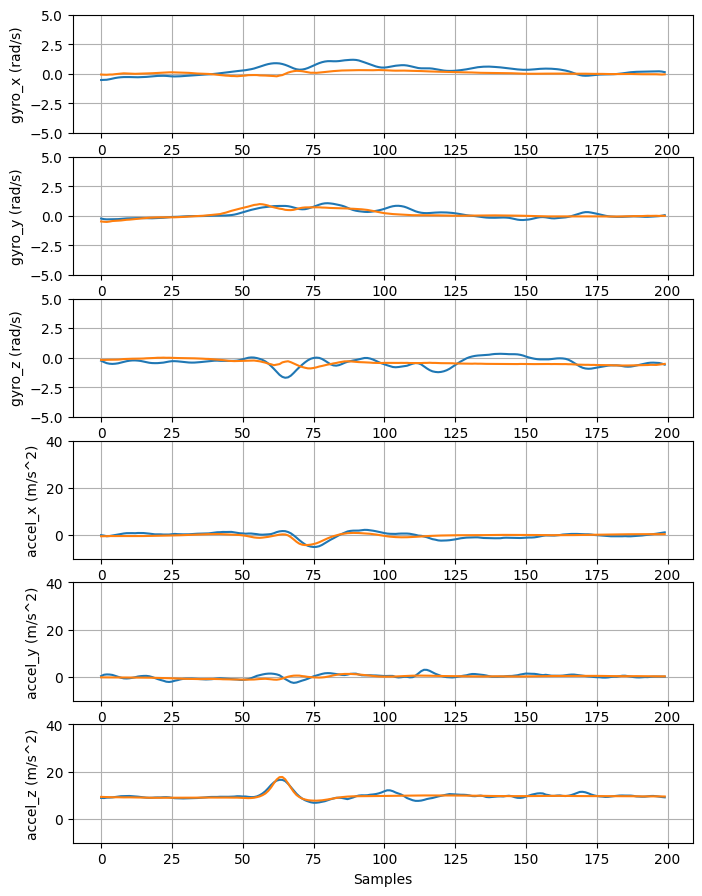

In [42]:
for batch_id, (feat, _, _, _) in enumerate(self_sup_train_loader):
    feat = feat.to(device)
    latent, _, out_feat = model(feat)
    break


def plot_recon_example(orig, recond):
    x_axis = np.arange(200)
    plt.figure(figsize=(8,12))
    titles = ['gyro_x (rad/s)', 'gyro_y (rad/s)', 'gyro_z (rad/s)', 'accel_x (m/s^2)', 'accel_y (m/s^2)', 'accel_z (m/s^2)']
    for i in range(6):
        plt.subplot(6, 1, i+1)
        plt.plot(x_axis, orig[i, :].squeeze().cpu().detach().numpy())
        plt.plot(x_axis, recond[i, :].squeeze().cpu().detach().numpy())
        if i < 3:
            plt.ylim(-5, 5)
        else:
            plt.ylim(-10, 40)
        plt.ylabel(titles[i])
        plt.xlabel('Samples')
        plt.grid(True)
    plt.subplots_adjust(top=0.8)
    plt.show()

batch_id = 30
plot_recon_example(feat[batch_id, :, :].squeeze(), out_feat[batch_id, :, :].squeeze())

# Load test data

In [38]:
with open('datasets/ronin_test_seen_list.txt') as f:
    ronin_test_seen_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
with open('datasets/ronin_test_unseen_list.txt') as f:
    ronin_test_unseen_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']

ronin_test_seen_dataset = data_glob_speed.StridedSequenceDataset(data_glob_speed.GlobSpeedSequence,
                                                             DATA_ROOT_DIR,
                                                             ronin_test_seen_list,
                                                             cache_path='datasets/cache')
ronin_test_unseen_dataset = data_glob_speed.StridedSequenceDataset(data_glob_speed.GlobSpeedSequence,
                                                             DATA_ROOT_DIR,
                                                             ronin_test_unseen_list,
                                                             cache_path='datasets/cache')

batch_size = 128
seen_loader = DataLoader(ronin_test_seen_dataset, batch_size=batch_size, shuffle=False)
unseen_loader = DataLoader(ronin_test_seen_dataset, batch_size=batch_size, shuffle=False)

a000_11: device: asus6, ori_error (game_rv): 16.363
a000_7: device: asus4, ori_error (game_rv): 8.354
a001_2: device: asus7, ori_error (game_rv): 8.617
a003_3: device: samsung1, ori_error (game_rv): 1.669
a004_3: device: asus3, ori_error (game_rv): 14.735
a005_3: device: samsung1, ori_error (game_rv): 1.271
a009_1: device: asus4, ori_error (game_rv): 2.222
a010_2: device: samsung1, ori_error (game_rv): 17.991
a011_2: device: samsung1, ori_error (ekf): 8.150
a012_2: device: samsung1, ori_error (game_rv): 4.979
a013_2: device: asus4, ori_error (game_rv): 5.244
a014_2: device: asus4, ori_error (game_rv): 7.929
a016_1: device: asus4, ori_error (game_rv): 5.513
a017_2: device: samsung1, ori_error (game_rv): 4.091
a018_1: device: asus4, ori_error (game_rv): 0.988
a020_2: device: asus3, ori_error (game_rv): 3.441
a021_2: device: samsung1, ori_error (game_rv): 6.462
a022_2: device: asus5, ori_error (game_rv): 3.583
a023_1: device: asus5, ori_error (game_rv): 7.791
a025_2: device: samsung1, ori

In [41]:
def test(data_loader):
    nelbos = []
    kls = []
    recs = []
    for batch_id, (feat, _, _, _) in enumerate(data_loader):
        feat = feat.to(device)
        nelbo, kl, rec = model.negative_elbo_bound(feat)

        nelbos.append(nelbo.cpu().detach().numpy())
        kls.append(kl.cpu().detach().numpy())
        recs.append(rec.cpu().detach().numpy())

    nelbo_avg = np.average(nelbos)
    kl_avg = np.average(kls)
    rec_avg = np.average(recs)
    return nelbo_avg, kl_avg, rec_avg

print(test(seen_loader))
print(test(unseen_loader))


(1002.01465, 90.01378, 912.00085)
(1002.0185, 90.04238, 911.9761)


In [73]:
# Average rec error on the training set
print(test(self_sup_train_loader))

(748.92554, 92.012924, 656.91254)


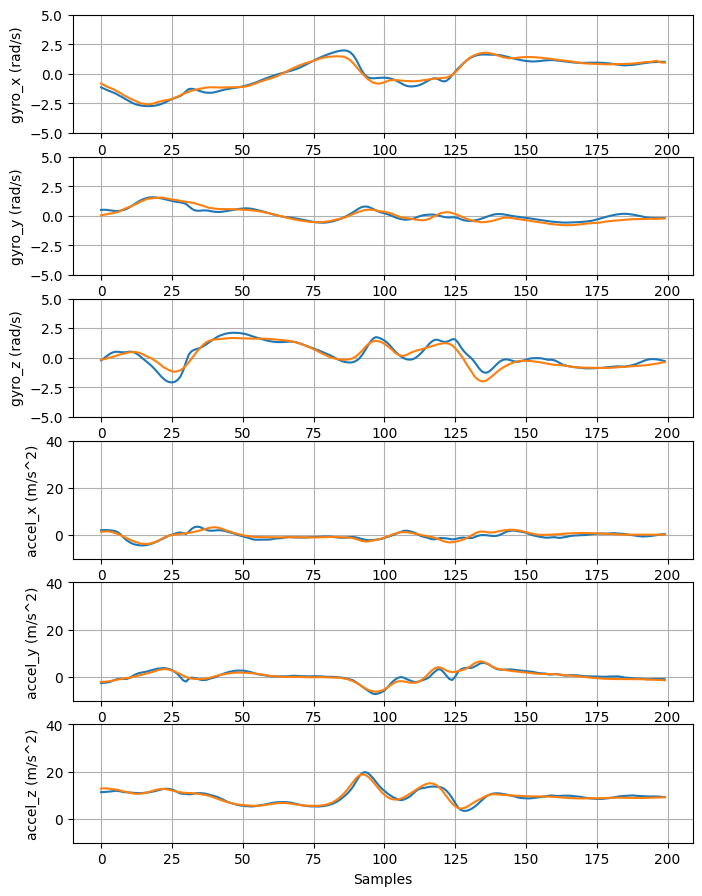

In [64]:
# Check some plots
for batch_id, (feat, _, _, _) in enumerate(seen_loader):
    if batch_id != 70:
        continue
    feat = feat.to(device)
    latent, _, out_feat = model(feat)
    plot_recon_example(feat[batch_id, :, :].squeeze(), out_feat[batch_id, :, :].squeeze())
    break

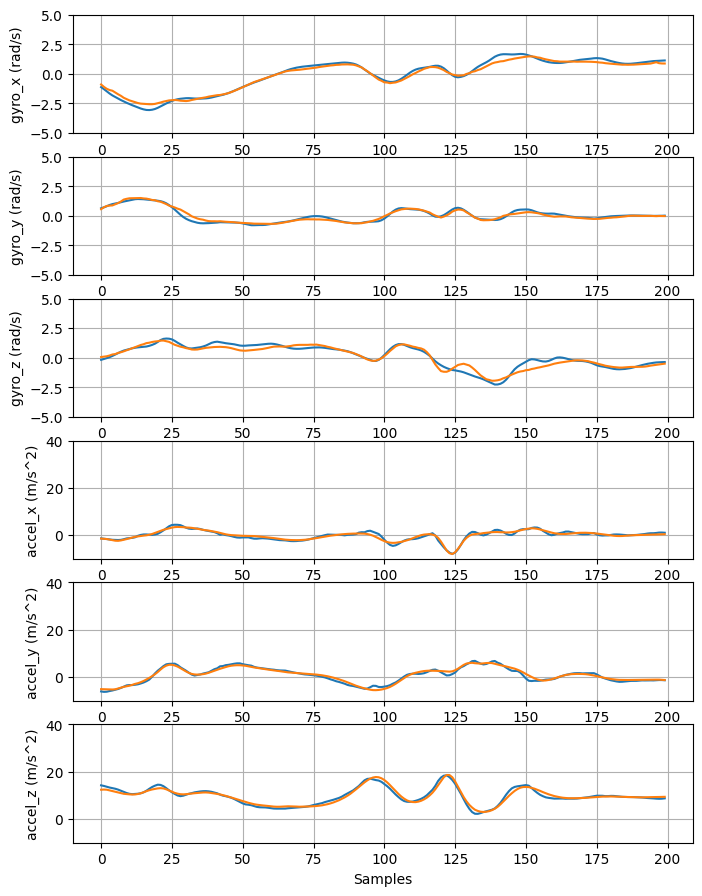

In [72]:
for batch_id, (feat, _, _, _) in enumerate(unseen_loader):
    if batch_id != 20:
        continue
    feat = feat.to(device)
    latent, _, out_feat = model(feat)
    plot_recon_example(feat[batch_id, :, :].squeeze(), out_feat[batch_id, :, :].squeeze())
    break